Import and load dataset

In [1]:
import pandas as pd

df = pd.read_csv("prepared_data/final_dataset.csv")

In [2]:
df.head()

,city_latitude,city_longitude,day_tempmax,day_tempmin,day_temp,day_precipcover,day_moonphase,hour_datetimeEpoch,hour_temp,hour_humidity,...,rifle,significant,southeast,southwest,state,unit,unspecified,wagner,within,would
0,50.7469,25.3263,4.9,0.7,2.6,4.17,0.77,1645653600,2.4,89.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49.2336,28.4486,5.0,0.7,2.8,4.17,0.77,1645653600,2.1,91.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,48.5085,32.2656,6.2,-1.3,2.2,0.00,0.77,1645653600,0.0,82.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49.4168,26.9743,4.7,0.2,2.3,8.33,0.77,1645653600,2.2,88.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.8289,35.1626,8.0,-2.0,3.3,0.00,0.77,1645653600,1.0,80.38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Importing essential libraries for machine learning

In [8]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, \
    classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import numpy as np

Dividing the dataset into features (X) and target (y)

In [50]:
X_regression = df.drop(["alarms_start_epoch", "alarms_end_epoch", "is_alarm"], axis=1)
y_regression = df["alarms_start_epoch"]

X_classification = df.drop(["alarms_start_epoch", "alarms_end_epoch", "is_alarm"], axis=1)
y_classification = df["is_alarm"]

### Creating Pipelines for Regression and Classification

For our tasks, both regression and classification can benefit from a similar pipeline structure, which involves preprocessing steps followed by model application. However, we handle certain steps differently depending on whether we are working on regression or classification.

1. **Feature Scaling**: We standardize numerical attributes using `StandardScaler` to ensure that the scale of the data does not influence the model's performance.

2. **Handling Categorical Features**: We use `OneHotEncoder` to encode categorical attributes. This transformation turns categorical variables into a format that can be used by machine learning models, ensuring that no important information is lost during the encoding process.

3. **ColumnTransformer**: We apply different transformations to numerical and categorical features separately. Numerical features are standardized with `StandardScaler`, and categorical features are encoded with `OneHotEncoder`. This step ensures that each type of feature is properly prepared for modeling.

4. **Dimensionality Reduction**: For regression tasks, we intentionally avoid applying Principal Component Analysis (PCA). We have found that PCA can negatively impact our model's performance by removing valuable information. In contrast, for classification tasks, we apply PCA to reduce the dimensionality of the feature space, capturing the most important features and improving model performance by focusing on the most relevant components.

In [6]:
num_attribs = X_regression.select_dtypes(include="number").columns.tolist()
cat_attribs = ["hour_conditions", "region", "hour_preciptype"]

num_regression_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

full_regression_pipeline = ColumnTransformer([
    ("num", num_regression_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)
])
regression_pipeline = Pipeline([
    ("preprocessor", full_regression_pipeline),
    ("model", LinearRegression())
])

In [7]:
num_classification_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("pca", PCA())
])

full_classification_pipeline = ColumnTransformer([
    ("num", num_classification_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
])
classification_pipeline = Pipeline([
    ("preprocessor", full_classification_pipeline),
    ("model", LogisticRegression())
])

## Linear Regression

As we are working with **time series data**, it is essential to properly train and test the model. Therefore, we use `TimeSeriesSplit` to ensure an appropriate split.

In [9]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []
for train_index, test_index in tscv.split(X_regression):
    X_train, X_test = X_regression.iloc[train_index], X_regression.iloc[test_index]
    y_train, y_test = y_regression.iloc[train_index], y_regression.iloc[test_index]

    regression_pipeline.fit(X_train, y_train)
    y_pred = regression_pipeline.predict(X_test)

    rmse_scores.append(root_mean_squared_error(y_test, y_pred) / 3600)
    mae_scores.append(mean_absolute_error(y_test, y_pred) / 3600)
    r2_scores.append(r2_score(y_test, y_pred))

### 1. RMSE (Root Mean Squared Error)

Since we're predicting the epoch start time of alarms, the **RMSE** we get is in seconds. To make it easier to interpret, we divide the result by 3600 to convert it into hours.

**RMSE** tells us how far off our predictions are on average. It works by taking the difference between the predicted values and the actual values, squaring those differences, averaging them, and then taking the square root.

The lower the **RMSE**, the better, because it means our model is predicting the start times more accurately. If the **RMSE** is higher, it means the predictions are more off.

In [10]:
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} hours")

RMSE scores: [3.213696958751725, 1.9695439708580424, 1.9855408959602718, 3.2314709893520353, 2.7752980585605167]
Mean RMSE: 2.6351 hours


Looking at the **RMSE** values, we can see that the average error is around **2.6 hours**, which means the model's predictions are, on average, off by about **2 to 3 hours**. This is fairly reasonable, but let's also consider other evaluation metrics to get a more complete view of the model's performance.

### 2. MAE (Mean Absolute Error)

**MAE** is another metric we use to measure how far off our predictions are, similar to **RMSE**. However, instead of squaring the differences between predicted and actual values like **RMSE** does, **MAE** calculates the average of the absolute differences.

Both **MAE and RMSE** provide similar insights, but **MAE** is less sensitive to large errors, as it doesn’t square the differences. This makes it useful for understanding the typical error size without being too influenced by outliers.

In [11]:
print(f"\nMAE scores: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} hours")


MAE scores: [2.3805569410481935, 1.478012955541068, 1.4692968342121968, 1.793105453287529, 1.9443164315701456]
Mean MAE: 1.8131 hours


Looking at the MAE values, we can see that the average error is around **1.8 hours**. This is fairly reasonable, and the results suggest that the model is performing well, with the error not being overly large.

### 3. R² (R-squared)

**R²** measures how well the model's predictions match the actual data by calculating the proportion of variance in the target variable that is explained by the model.

  - An **R² value of 1** means the model explains **100% of the variance** in the target variable, i.e., it perfectly predicts the outcome.
  - An **R² value of 0** means the model explains **0% of the variance**, indicating that the model does no better than simply predicting the mean of the target variable.
  - Negative **R² values** can occur when the model performs worse than a horizontal line predicting the mean.

**R² (R-squared)** is calculated as:

  R² = 1 - (SS_residual / SS_total)

  Where:
  - **SS_residual** is the sum of squared residuals, which is the sum of the squared differences between the predicted and actual values.
  - **SS_total** is the total sum of squares, which is the sum of the squared differences between the actual values and the mean of the target variable.

In [12]:
print(f"\nR² scores: {r2_scores}")
print(f"Mean R²: {np.mean(r2_scores):.4f}")


R² scores: [0.9999938494867541, 0.9999976502004608, 0.9999975732881771, 0.9999933014356215, 0.9999951959123544]
Mean R²: 1.0000


While the R² scores look excellent, there is a key factor that may be skewing these results — the nature of the **epoch time data**. Epoch time represents the number of seconds since January 1, 1970, which results in very large numeric values. The differences between two consecutive epoch times are typically small (just a few seconds), but since the numbers themselves are so large, even small prediction errors become relatively insignificant in comparison.

Although the high R² values suggest excellent model performance, we cannot solely rely on R² when working with epoch time data. The scale of the numbers can artificially inflate the R² score, making the model appear more accurate than it might be in practice.

### Identifying the Best Model

**Linear regression** generally has few hyperparameters, and tuning them doesn't often lead to significant improvements in model performance. For this reason, the default hyperparameters are commonly used. However, we will explore some options for tuning in this case.

- **model__fit_intercept**: Specifies whether the model should calculate an intercept.
  - `True` includes an intercept in the model.
  - `False` forces the model to pass through the origin, with no intercept.

- **model__copy_X**: Determines whether the input data `X` should be copied before fitting.
  - `True` copies the data to avoid modifying the original dataset.
  - `False` modifies the data in place, saving memory.

- **model__positive**: Ensures that the model’s coefficients are constrained to be positive.
  - `True` restricts all coefficients to non-negative values.
  - `False` allows coefficients to take any real value, including negative ones.

In [13]:
param_regression_grid = {
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False],
    "model__positive": [False, True]
}

We use **`GridSearchCV`** since there are a limited number of hyperparameters to tune. This method evaluates all possible combinations of the specified hyperparameters and helps us identify the best model.

Another option is **`RandomizedSearchCV`**, which we will use in the case of classification. Unlike `GridSearchCV`, `RandomizedSearchCV` randomly samples from a range of hyperparameters, making it more efficient for models with a larger number of hyperparameters or when the search space is very large.

In [19]:
grid_search = GridSearchCV(
    regression_pipeline,
    param_regression_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_regression, y_regression)
best_regression_model = grid_search.best_estimator_
best_regression_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['city_latitude',
                                                   'city_longitude',
                                                   'day_tempmax', 'day_tempmin',
                                                   'day_temp',
                                                   'day_precipcover',
                                                   'day_moonphase',
                                                   'hour_datetimeEpoch',
                                                   'hour_temp', 'hour_humidity',
                                                   'hour_dew', 'hour_precip',
                                                   'hour_precipprob',
                                                   'hour_snow',
                                                   'hour_snowdepth',
                                                   'hour_windgust',
                                                   'hour_windspeed',
                                                   'hour_winddir',
                                                   'hour_pressure',
                                                   'hour_visibility',
                                                   'hour_cloudcover',
                                                   'hour_solarradiation',
                                                   'hour_solarenergy',
                                                   'hour_uvindex', 'advanced',
                                                   'air', 'army', 'artillery',
                                                   'authority', 'avdiivka', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour_conditions', 'region',
                                                   'hour_preciptype'])])),
                ('model', LinearRegression())])

In [20]:
grid_search.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__positive': False}

As we can see, these are essentially the default parameters, so the results remain identical.

In [22]:
print(f"Best RMSE: {-grid_search.best_score_ / 3600:.4f} hours")

Best RMSE: 2.6351 hours


In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

97.39813462730208 {'model__copy_X': True, 'model__fit_intercept': True, 'model__positive': False}
nan {'model__copy_X': True, 'model__fit_intercept': True, 'model__positive': True}
1838.0781661747349 {'model__copy_X': True, 'model__fit_intercept': False, 'model__positive': False}
nan {'model__copy_X': True, 'model__fit_intercept': False, 'model__positive': True}
97.39813462730208 {'model__copy_X': False, 'model__fit_intercept': True, 'model__positive': False}
nan {'model__copy_X': False, 'model__fit_intercept': True, 'model__positive': True}
1838.0781661747349 {'model__copy_X': False, 'model__fit_intercept': False, 'model__positive': False}
nan {'model__copy_X': False, 'model__fit_intercept': False, 'model__positive': True}


We can observe that when `model__positive` is set to `True`, the model produces a `nan` score.

### Top Features for the Regression Task

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
feature_importance = list(zip(X_regression.columns, abs(grid_search.best_estimator_["model"].coef_)))
importance_df = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values("Importance", ascending=False)
top_20 = importance_df.head(20)

This bar plot visualizes the top 20 features of the linear regression model based on their **absolute coefficient values**, which represent the importance of each feature.

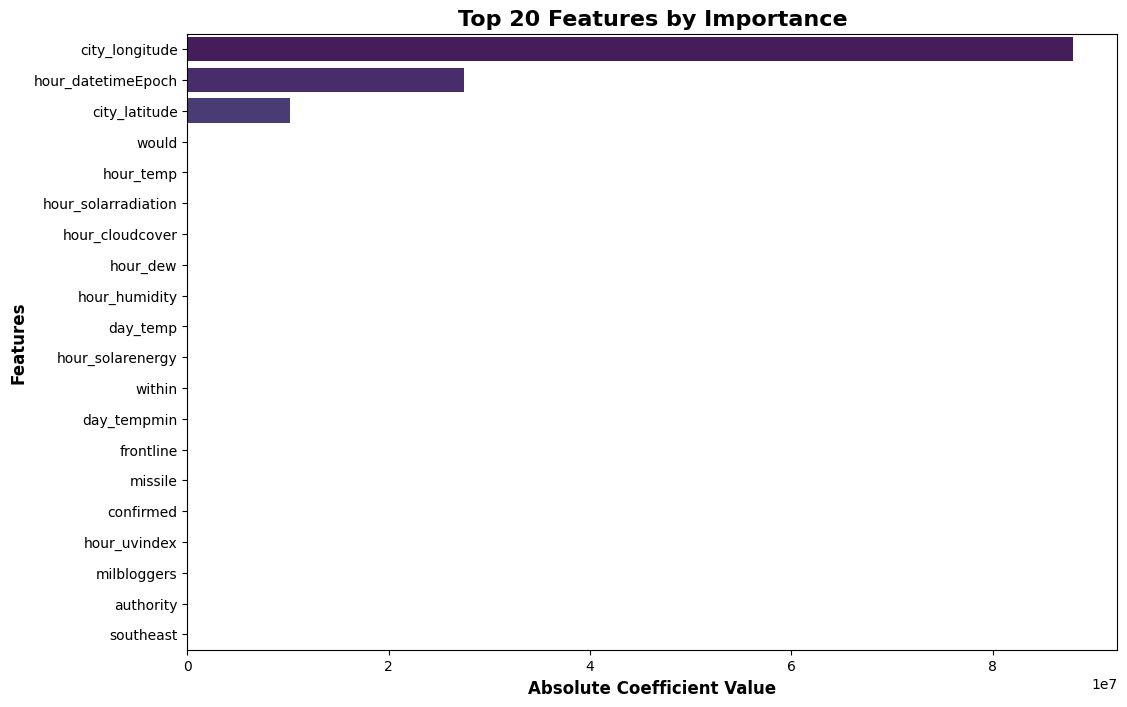

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=top_20, palette="viridis")
plt.title("Top 20 Features by Importance", fontsize=16, fontweight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12, fontweight="bold")
plt.ylabel("Features", fontsize=12, fontweight="bold");

We can observe a strong dependence on features like `city_longitude`, `hour_datetimeEpoch`, and `city_latitude`, which dominate the model. These features have significantly higher coefficients compared to the others. To better understand the influence of other features, let's plot the feature importance again, excluding these three, and identify the remaining important features.

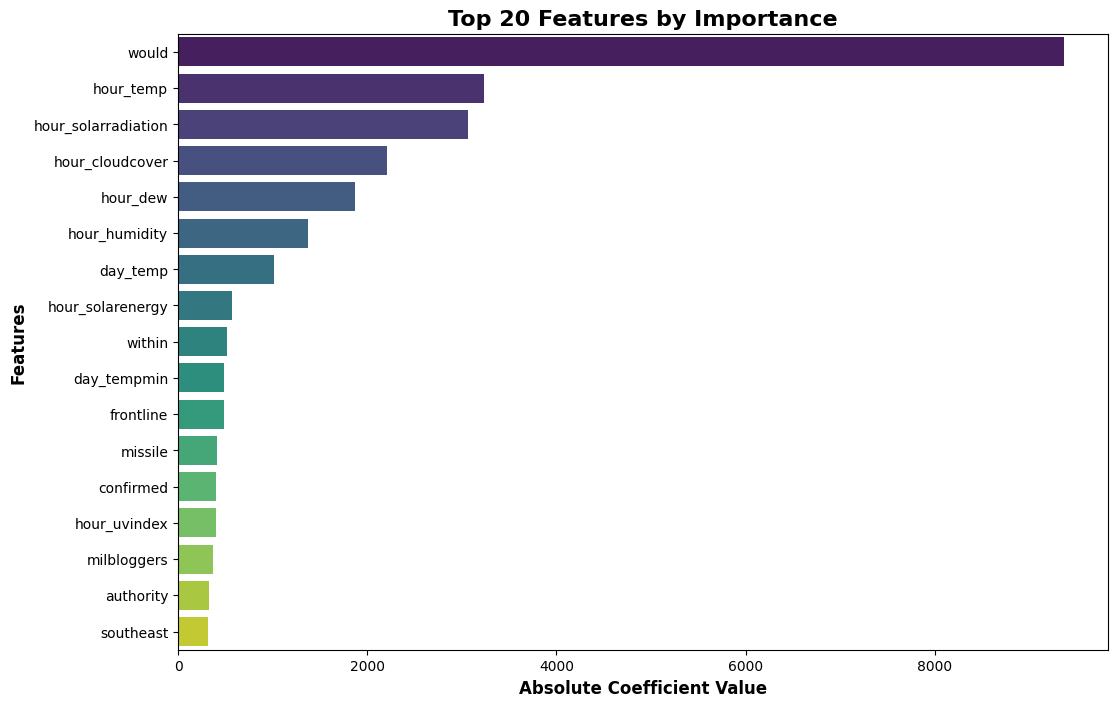

In [45]:
top_20 = top_20.iloc[3:]
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=top_20, palette="viridis")
plt.title("Top 20 Features by Importance", fontsize=16, fontweight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12, fontweight="bold")
plt.ylabel("Features", fontsize=12, fontweight="bold");

- The feature **`would`** stands out as the most important, with a significantly higher coefficient compared to the other features. This indicates it has a strong influence on the model’s predictions.
- **`hour_temp`**, **`hour_solarradiation`**, and **`hour_cloudcover`** are also highly influential features.

### Conclusion on the Regression Part

1. The overall result is quite good. An MAE of 1.8 hours for predicting the next alarm is a strong outcome, but there is still room for improvement.
2. A significant dependence on features like `city_latitude` and `city_longitude` is observed. We should consider testing the model without these features to evaluate their true impact. The `hour_datetimeEpoch` column, however, remains valuable as it provides temporal information, making it easier to predict the correct time.
3. The weather data appears to be much more valuable in predicting the target than the **ISW reports**, indicating that weather-related features play a more substantial role.

Check the Model Without the Mentioned Columns

In [51]:
X_regression.drop(["city_longitude", "city_latitude"], axis=1, inplace=True)
num_attribs = X_regression.select_dtypes(include="number").columns.tolist()
cat_attribs = ["hour_conditions", "region", "hour_preciptype"]

num_regression_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

full_regression_pipeline = ColumnTransformer([
    ("num", num_regression_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)
])
regression_pipeline = Pipeline([
    ("preprocessor", full_regression_pipeline),
    ("model", LinearRegression())
])

In [52]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []
for train_index, test_index in tscv.split(X_regression):
    X_train, X_test = X_regression.iloc[train_index], X_regression.iloc[test_index]
    y_train, y_test = y_regression.iloc[train_index], y_regression.iloc[test_index]

    regression_pipeline.fit(X_train, y_train)
    y_pred = regression_pipeline.predict(X_test)

    rmse_scores.append(root_mean_squared_error(y_test, y_pred) / 3600)
    mae_scores.append(mean_absolute_error(y_test, y_pred) / 3600)
    r2_scores.append(r2_score(y_test, y_pred))
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} hours")
print(f"\nMAE scores: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} hours")

RMSE scores: [3.2136969564302547, 1.966689577226994, 1.983196086078611, 3.2315260013332443, 2.775012777213613]
Mean RMSE: 2.6340 hours

MAE scores: [2.3805569382436427, 1.4767773556882438, 1.4663877813559871, 1.7943548786700707, 1.9449388075046001]
Mean MAE: 1.8126 hours


We can see that the results have slightly improved, but the difference is less than 3 seconds. This indicates that the model’s performance doesn’t heavily depend on the `city_latitude` and `city_longitude` columns.

## Classification

In [37]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
avg_precision_scores = []
confusion_matrices = []
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_classification):
    X_train, X_test = X_classification.iloc[train_index], X_classification.iloc[test_index]
    y_train, y_test = y_classification.iloc[train_index], y_classification.iloc[test_index]

    classification_pipeline.fit(X_train, y_train)
    y_pred = classification_pipeline.predict(X_test)

    y_pred_proba = classification_pipeline.predict_proba(X_test)[:, 1]

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average="binary", zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, average="binary", zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, average="binary", zero_division=0))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    avg_precision_scores.append(average_precision_score(y_test, y_pred_proba))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

print(f"Accuracy scores: {accuracy_scores}")
print(f"Mean accuracy: {np.mean(accuracy_scores):.4f}")

print(f"\nPrecision scores: {precision_scores}")
print(f"Mean precision: {np.mean(precision_scores):.4f}")

print(f"\nRecall scores: {recall_scores}")
print(f"Mean recall: {np.mean(recall_scores):.4f}")

print(f"\nF1 scores: {f1_scores}")
print(f"Mean F1: {np.mean(f1_scores):.4f}")

print(f"\nROC AUC scores: {roc_auc_scores}")
print(f"Mean ROC AUC: {np.mean(roc_auc_scores):.4f}")

print(f"\nAverage Precision scores: {avg_precision_scores}")
print(f"Mean Average Precision: {np.mean(avg_precision_scores):.4f}")

print(f"\n Confusion Matrices scores: {confusion_matrices}")

C:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy scores: [0.795848078269591, 0.7879378536419204, 0.7735556270461555, 0.7438828227012092, 0.7178812709346555]
Mean accuracy: 0.7638

Precision scores: [0.48840688107703817, 0.5855068566819037, 0.7204404021062709, 0.7489844903988183, 0.6600912651359995]
Mean precision: 0.6407

Recall scores: [0.12176020883833676, 0.3490142651065876, 0.26369274976346496, 0.4286242603550296, 0.47437188524801815]
Mean recall: 0.3275

F1 scores: [0.19492537313432837, 0.43733681462140994, 0.3860756246472731, 0.545228494623656, 0.5520298085879984]
Mean F1: 0.4231

ROC AUC scores: [np.float64(0.6697427455967151), np.float64(0.7438357809757561), np.float64(0.7698602757683233), np.float64(0.8014714870688231), np.float64(0.7899040420977347)]
Mean ROC AUC: 0.7550

Average Precision scores: [np.float64(0.3700435133894332), np.float64(0.5022898570873144), np.float64(0.5867259359997006), np.float64(0.6961145579826867), np.float64(0.6758824406531853)]
Mean Average Precision: 0.5662

 Confusion Matrices scores: 

In [38]:
confusion_matrices[0]

array([[81498,  2736],
       [18840,  2612]])

In [40]:
df.shape

(634121, 80)

In [46]:
df.shape[0] / 6

105686.83333333333

In [50]:
df[int(df.shape[0] / 6) * 5:int(df.shape[0] / 6) * 6:]["is_alarm"].value_counts()

is_alarm
0    66962
1    38724
Name: count, dtype: int64

In [15]:
param_grid = {
    "preprocessor__num__pca__n_components": [0.5, 0.2, 0.01, 0.95, 0.9, 0.8, 1, 5, 10, 25, 50, 70]
}

In [16]:
grid_search = GridSearchCV(
    classification_pipeline,
    param_grid,
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_classification, y_classification)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")

best_classification_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'preprocessor__num__pca__n_components': 70}
Best accuracy: 0.7645


C:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
